In [1]:
# !pip install implicit

# Load MovieLens data

In [2]:
import numpy as np
import pandas as pd
import time
from scipy.sparse import csr_matrix

ratings = pd.read_csv(
    "https://files.grouplens.org/datasets/movielens/ml-100k/u.data",
    sep="\t",
    names=["user", "item", "rating", "timestamp"]
)

# convert to 0-based index
ratings["user"] -= 1
ratings["item"] -= 1

# implicit feedback: rating >= 4
ratings["implicit"] = (ratings["rating"] >= 4).astype(int)

df = ratings[ratings["implicit"] == 1].copy()

print(df.head())

n_users = df.user.max() + 1
n_items = df.item.max() + 1

R = csr_matrix(
    (np.ones(len(df)), (df.user.values, df.item.values)),
    shape=(n_users, n_items)
)

print("Matrix shape:", R.shape)


    user  item  rating  timestamp  implicit
5    297   473       4  884182806         1
7    252   464       5  891628467         1
11   285  1013       5  879781125         1
12   199   221       5  876042340         1
16   121   386       5  879270459         1
Matrix shape: (943, 1674)


# ALS

In [3]:
from implicit.als import AlternatingLeastSquares

als = AlternatingLeastSquares(
    factors=64,
    regularization=0.1,
    iterations=20
)

start = time.time()
als.fit(R)
als_time = time.time() - start

print(f"ALS training time: {als_time:.2f}s")


/Users/codexplore/miniforge3/envs/recsys/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/codexplore/miniforge3/envs/recsys/lib/python3.11/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 12 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()
100%|██████████| 20/20 [00:00<00:00, 333.22it/s]

ALS training time: 0.07s


# BPR-MF

In [4]:
from implicit.bpr import BayesianPersonalizedRanking

bpr = BayesianPersonalizedRanking(
    factors=64,
    learning_rate=0.05,
    regularization=0.01,
    iterations=50,
    verify_negative_samples=True
)

start = time.time()
bpr.fit(R)
bpr_time = time.time() - start

print(f"BPR training time: {bpr_time:.2f}s")


100%|██████████| 50/50 [00:00<00:00, 510.10it/s, train_auc=96.96%, skipped=22.80%]

BPR training time: 0.10s


In [5]:
pd.DataFrame({
    "model": ["ALS", "BPR"],
    "training_time_sec": [als_time, bpr_time]
})

,model,training_time_sec
0,ALS,0.072250
1,BPR,0.100796


# 2-Stages Retrieval (ALS) & Ranking (BPR)

In [6]:
# Stage-1: Candidate retrieval (ALS)
def retrieve_candidates(als_model, R_train, user_id, C=100):
    items, _ = als_model.recommend(
        userid=user_id,
        user_items=R_train[user_id],
        N=C,
        filter_already_liked_items=True
    )
    return np.array(items)

# Stage-2: Ranking with BPR
def rank_with_bpr(bpr_model, user_id, candidate_items, K=10):
    user_vec = bpr_model.user_factors[user_id]
    item_vecs = bpr_model.item_factors[candidate_items]

    scores = item_vecs @ user_vec
    top_k_idx = np.argsort(scores)[::-1][:K]

    return candidate_items[top_k_idx]

# Full 2-stage recommender
def recommend_2stage(als, bpr, R_train, user_id, C=100, K=10):
    candidates = retrieve_candidates(als, R_train, user_id, C)
    return rank_with_bpr(bpr, user_id, candidates, K)

# ALS-only recommender
def recommend_als(als, R_train, user_id, K=10):
    items, _ = als.recommend(
        userid=user_id,
        user_items=R_train[user_id],
        N=K,
        filter_already_liked_items=True
    )
    return np.array(items)



## Recall for ALS

In [7]:
def recall_at_k_als(als, R_train, test_items, K=10):
    """
    test_items: dict {user_id: set(true_items)}
    """
    recalls = []

    for u, true_items in test_items.items():
        recs = recommend_als(als, R_train, u, K)

        hits = len(set(recs) & set(true_items))
        recall = hits / len(true_items)

        recalls.append(recall)

    return np.mean(recalls)

## Hit Rate, NDCG, MAP for BPR

In [8]:
def hit_rate_at_k_2stage(als, bpr, R_train, test_items, K=10):
    hits = []

    for u, true_items in test_items.items():
        recs = recommend_2stage(als, bpr, R_train, u, C=100, K=K)

        hit = int(len(set(recs) & set(true_items)) > 0)
        hits.append(hit)

    return np.mean(hits)

def ndcg_at_k_2stage(als, bpr, R_train, test_items, K=10):
    ndcgs = []

    for u, true_items in test_items.items():
        recs = recommend_2stage(als, bpr, R_train, u, C=100, K=K)

        dcg = 0.0
        for idx, item in enumerate(recs):
            if item in true_items:
                dcg += 1 / np.log2(idx + 2)

        # Ideal DCG
        ideal_hits = min(len(true_items), K)
        idcg = sum(1 / np.log2(i + 2) for i in range(ideal_hits))

        ndcgs.append(dcg / idcg if idcg > 0 else 0.0)

    return np.mean(ndcgs)

def map_at_k_2stage(als, bpr, R_train, test_items, K=10):
    aps = []

    for u, true_items in test_items.items():
        recs = recommend_2stage(als, bpr, R_train, u, C=100, K=K)

        hit_count = 0
        score = 0.0

        for idx, item in enumerate(recs):
            if item in true_items:
                hit_count += 1
                score += hit_count / (idx + 1)

        ap = score / min(len(true_items), K) if true_items else 0.0
        aps.append(ap)

    return np.mean(aps)


## Train / Test split (leave-last-out per user)

In [ ]:
df = df.sort_values(["user"]).reset_index(drop=True)

train_rows = []
test_rows = []

for u, g in df.groupby("user"):
    if len(g) < 2:
        continue
    # need to sort by timestamp to get the latest interaction
    g = g.sort_values("timestamp")

    test_rows.append(g.iloc[-1])
    train_rows.append(g.iloc[:-1])

train_df = pd.concat(train_rows)
test_df = pd.DataFrame(test_rows)

#
R_train = csr_matrix(
    (
        train_df["implicit"],
        (train_df["user"], train_df["item"])
    ),
    shape=(n_users, n_items)
)

#
test_items = (
    test_df
    .groupby("user")["item"]
    .apply(set)
    .to_dict()
)

In [16]:
als = AlternatingLeastSquares(
    factors=64,
    regularization=0.1,
    iterations=20
)
als.fit(R_train)

100%|██████████| 20/20 [00:00<00:00, 301.12it/s]


In [17]:
bpr = BayesianPersonalizedRanking(
    factors=64,
    learning_rate=0.05,
    regularization=0.01,
    iterations=50,
    verify_negative_samples=True
)
bpr.fit(R_train)

100%|██████████| 50/50 [00:00<00:00, 383.54it/s, train_auc=96.89%, skipped=23.17%]


## Evaluation

In [18]:
print("Recall@10 ALS:",
      recall_at_k_als(als, R_train, test_items, K=10))

print("HitRate@10 ALS → BPR:",
      hit_rate_at_k_2stage(als, bpr, R_train, test_items, K=10))

print("NDCG@10 ALS → BPR:",
      ndcg_at_k_2stage(als, bpr, R_train, test_items, K=10))

print("MAP@10 ALS → BPR:",
      map_at_k_2stage(als, bpr, R_train, test_items, K=10))


Recall@10 ALS: 0.1337579617834395
HitRate@10 ALS → BPR: 0.12632696390658174
NDCG@10 ALS → BPR: 0.06910827809955472
MAP@10 ALS → BPR: 0.05216274053853672


# Visualization

## ALS Item Embedding

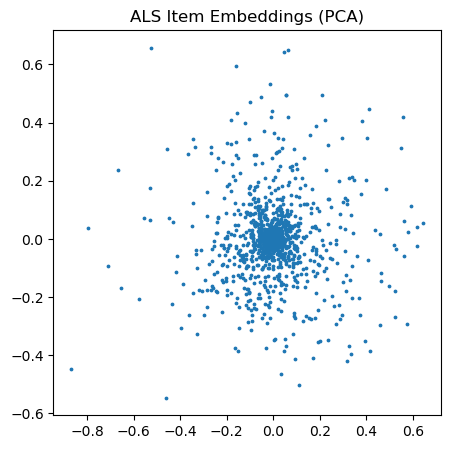

In [13]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)

X_als = pca.fit_transform(als.item_factors)

plt.figure(figsize=(5,5))
plt.scatter(X_als[:,0], X_als[:,1], s=3)
plt.title("ALS Item Embeddings (PCA)")
plt.show()


## BPR Item Embedding

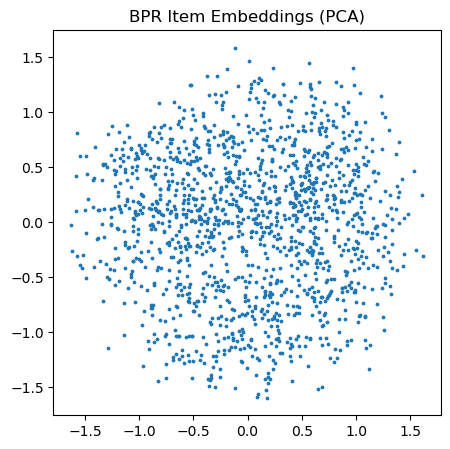

In [14]:
X_bpr = pca.fit_transform(bpr.item_factors)

plt.figure(figsize=(5,5))
plt.scatter(X_bpr[:,0], X_bpr[:,1], s=3)
plt.title("BPR Item Embeddings (PCA)")
plt.show()
